## Calculating the Vibrational Modes of the Formic Acid Dimer using a High-Dimensional Neural Network Potential

This Jupyter Notebook is written for the SPP tutorial in July 2023 by **Moritz R. Schäfer** (moritz.schaefer-f91@rub.de, Lehrstuhl für Theoretische Chemie II, Ruhr-Universität Bochum; Research Center Chemical Sciences and Sustainability, Research Alliance Ruhr).

The most recent version of RuNNer is [hosted on Gitlab](https://gitlab.com/TheochemGoettingen/RuNNer). For access please contact Prof. Dr. Jörg Behler (joerg.behler@rub.de).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import Layout, widgets, interact

from ase import Atoms
from ase.calculators.calculator import PropertyNotImplementedError
from ase.vibrations import Vibrations
from ase.optimize import BFGS

from runnerase import Runner, RunnerScaling, RunnerWeights
from runnerase import read_runnerconfig, read
from runnerase import generate_symmetryfunctions

from helpers import view_ngl, plot_energy
#from helpers import plot_energy
from ase.visualize import view

This global variable tells Python where to find the RuNNer executable. In this notebook we will use the outdated RuNNer version 1.1 which can be installed via conda/mamba. For production, you should compile the most recent version of RuNNer on your machine.

In [2]:
RUNNER_COMMAND = 'RuNNer.serial.x > PREFIX.out'

## Background

**RuNNer** is a stand-alone Fortran program for the construction of high-dimensional neural network potentials (HDNNPs), written mainly by Jörg Behler. The central assumption made in constructing a HDNNP is that the total energy of the system $E_{\mathrm{tot}}$ [can be separated into atomic contributions $E_i$](https://www.doi.org/10.1103/PhysRevLett.98.146401). HDNNP relates the local environment of the atoms to their atomic energies $E_i$, which contribute to the sum of all $N$ atomic energies, resulting in the total energy of the system $E_\mathrm{tot}$.

\begin{align}
    E_\mathrm{tot} = \sum_{i}^{N}E_i\notag
\end{align}

Every atomic energy is described by an atomic neural network (NN), which is element-specific. The entirety of all atomic NNs composes a HDNNP, whose general architecture is shown below for a binary system.

<div>
<img src="figures/2g.png" width="500"/>
</div>

As you can see, the atomic contributions in this model are predicted independently from each other. Therefore, the model can easily describe systems with differering numbers of atoms: adding or removing an atom corresponds to adding or removing a row in the figure shown above. This ability is what puts the "high-dimensional" into the name "HDNNP". 

Each atomic neural networks receives input information about the local atomic environment up to a certain cutoff radius $R_{\mathrm{c}}$. This information is encoded based on the Cartesian coordinates in many-body descriptors, so-called [atom-centered symmetry functions (ACSF or just SF)](https://www.doi.org/10.1063/1.3553717). For each atom, the values of multiple SFs compose a SF vector $G$ which is the input layer of the atomic NNs.

Atomic NNs look like this:

<div>
<img src="figures/ann.png" width="500"/>
</div>

Every value in the SF vector $G$ serves as one piece of input information to the atomic NN. We refer to the circles in the figure as _nodes_ (from graph theory) or _neurons_ (from neural science). The information from the input nodes flows through the atomic NN from left to right: the input layer is followed by a configurable number of hidden layers which consist, in turn, of an arbitrary number of _hidden nodes_. At the end, all information is collected in the output layer, which in our case is interpreted as the atomic energy contribution of the atom under consideration. The input nodes and the hidden nodes in the first layer are connected by weights. Moreover, the hidden and output nodes carry a bias value.

During training, the weights and biases are optimized using backpropagation to represent best the data in the training data set.

# Using RuNNer via the Atomic Simulation Environment (ASE)

In general, training a HDNNP with **RuNNer** can be separated into three different stages - so-called modes - in which different types of calculation are performed.

- **Mode 1:** calculation of the SF values and separation of the dataset into a training and testing set.
- **Mode 2:** training of the model to construct the HDNNP.
- **Mode 3:** prediction of energy and forces (stress and charges can also be predicted).

All these steps are performed consecutively beginning with mode 1.

The [Atomic Simulation Environment](https://wiki.fysik.dtu.dk/ase/index.html) (ASE) is "a set of tools and Python modules for setting up, manipulating, running, visualizing and analyzing atomistic simulations.". It can interact with varius standalone codes through so-called `calculators`. For example, you can run DFT calculations using VASP or FHIaims, or control MD simulations with LAMMPS.

We have implemented RuNNer in ASE so you can very easily set up and analyze HDNNPs from Python.

## Data Preparation

The creation of a meaningful neural network potential lives and dies with high quality training data. Therefore, we will begin by inspecting the full training dataset that was generated with highly accurate, explicitly correlated, frozen-core (fc-)CCSD(T)-F12a in conjunction with an aug-cc-pVTZ basis 95 for carbon and oxygen atoms and a cc-pVTZ basis for hydrogen atoms. This dataset as well as the fit loaded used in this notebook were published [in this paper](https://doi.org/10.1039/D2CP03893E) by Rasheeda *et al*. 

ASE comes with functions to read in a RuNNer dataset:

In [3]:
dataset = read('data/pretrained_potential/input.data', index=':', format='runner')

Now we can take a first at the distribution of energies in the dataset (we have written a small function in helpers.py for that):

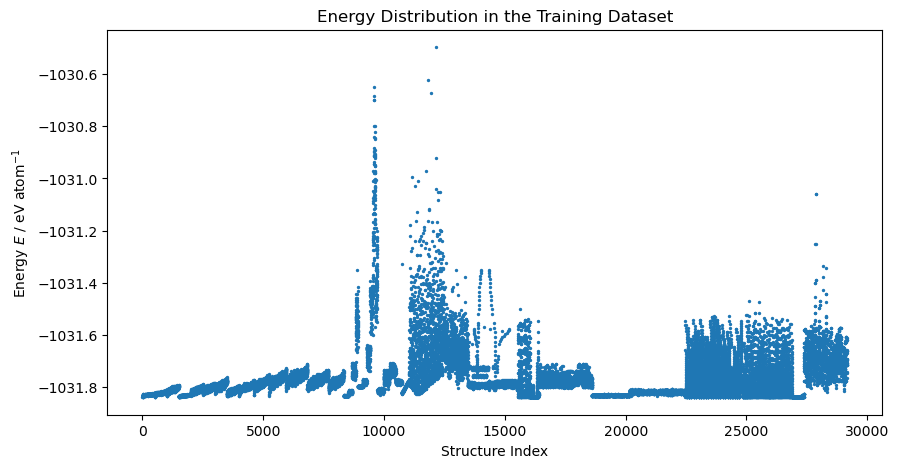

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plot_energy(dataset)
plt.show()

In this short notebook we will not use RuNNer to train a HDNNP potential but will limit ourselves to using an already fit potential. If you would like to find out how to fit a potential yourself, take a look at handson.ipynb.

## Working with a Final Potential

We have pretrained a potential for the formid acid dimer which you can simply load into ASE in a few lines of code: 

In [5]:
# Load the RuNNer parameters and files.
fad = read('data/fad_equilibrium.data', ':', format='runner')[0]
options = read_runnerconfig('data/pretrained_potential/input.nn')
scaling = RunnerScaling('data/pretrained_potential/scaling.data')
weights = RunnerWeights(path='data/pretrained_potential/')

# Create the calculator object.
runnercalc = Runner(scaling=scaling, weights=weights, **options, label='vib_calculation_pretrained/vib',
                    command=RUNNER_COMMAND)

In [6]:
view_ngl(fad)
#view(fad, viewer='ngl')

NGLWidget()

ASE provides a separate module for calculating the numerical Hessian. As a first step, we calculate the forces of the structure `fad`.

In [7]:
fad.calc = runnercalc
runnercalc.reset()

fad.get_forces()

array([[ 0.00000000e+00,  0.00000000e+00, -2.57110335e-04],
       [ 0.00000000e+00,  0.00000000e+00, -0.00000000e+00],
       [ 5.14220671e-05,  0.00000000e+00, -1.02844134e-04],
       [ 0.00000000e+00,  0.00000000e+00,  1.02844134e-04],
       [-2.57110335e-04,  0.00000000e+00, -2.05688268e-04],
       [-5.14220671e-04,  0.00000000e+00, -5.65642738e-04],
       [-0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.02844134e-04,  0.00000000e+00, -1.02844134e-04],
       [ 2.05688268e-04,  0.00000000e+00,  5.14220671e-04],
       [ 4.11376537e-04,  0.00000000e+00,  6.68486872e-04]])

In [8]:
vib = Vibrations(fad, name='vib_pretrained')
vib.run()
vib.summary()

---------------------
  #    meV     cm^-1
---------------------
  0    1.5i     12.1i
  1    1.0i      8.1i
  2    0.5       3.8
  3    1.0       7.7
  4    1.1       9.2
  5    1.3      10.7
  6    8.8      70.8
  7   20.7     166.6
  8   22.3     179.7
  9   26.5     214.1
 10   31.9     257.4
 11   34.1     274.9
 12   85.2     687.4
 13   88.2     711.6
 14  118.7     957.3
 15  121.4     979.0
 16  134.3    1083.1
 17  137.5    1108.7
 18  155.9    1257.1
 19  156.2    1259.7
 20  174.8    1409.7
 21  174.8    1410.1
 22  180.9    1459.1
 23  184.3    1486.1
 24  213.5    1721.7
 25  221.2    1784.1
 26  384.3    3099.8
 27  384.7    3102.8
 28  398.0    3209.8
 29  410.7    3312.4
---------------------
Zero-point energy: 1.936 eV


For reference, we will save the experimental frequencies obtained in an earlier study (see source below) and the harmonic frequencies obtained with the chose electronic structure method.

[F. Kollipost, R. Wugt Larsen, A. V. Domanskaya, M. Nörenberg, and M. A. Suhm
, "Communication: The highest frequency hydrogen bond vibration and an experimental value for the dissociation energy of formic acid dimer", J. Chem. Phys. 136, 151101 (2012)](https://doi.org/10.1063/1.4704827)

We can plot the frequencies in several different ways. Here, we are 'fold'ing together all frequencies in an interval of 40 wavenumbers to obtain a smooth plot. 

In [9]:
EXP_FREQUENCIES = np.array([69.2, 161, 168.47, 194, 242, 264, 677, 698, 911, 922, 1050, 1060, 1214, 1218,
                            1364, 1375, 1415, 1454, 1670, 1746, 2900, 2938.5, 2949, 3084])

CCSDT_FREQUENCIES = np.array([76.36, 170.96, 185.95, 211.28, 257.76, 278.07, 687.78, 715.81, 959.6, 986.46,
                              1085.04, 1102.03, 1256.78, 1260.06, 1405.06, 1413.1, 1455.96, 1483.92, 1717.13,
                              1781.57, 3100.56, 3104.59, 3203.36, 3305.25])

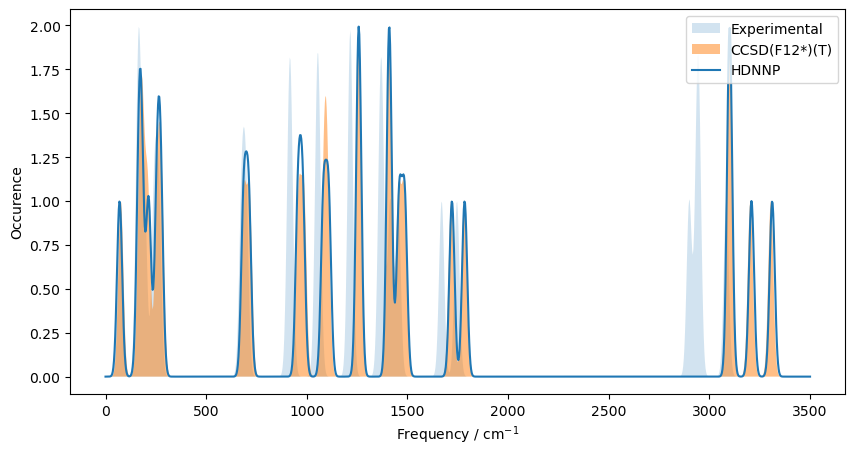

In [10]:
ase_frequencies = vib.get_frequencies()[6:].real.astype(int)

intensities = np.ones(len(ase_frequencies))
energies_hdnnp, spectrum_hdnnp = vib.fold(ase_frequencies, intensities, start=0.,
                                          end=3500., type='Gaussian', width=30.0)

energies_exp, spectrum_exp = vib.fold(EXP_FREQUENCIES, intensities, start=0.,
                                          end=3500., type='Gaussian', width=30.0)

energies_ccsdt, spectrum_ccsdt = vib.fold(CCSDT_FREQUENCIES, intensities, start=0.,
                                        end=3500., type='Gaussian', width=30.0)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# Plot experimental data.
# ax.plot(energies_exp, spectrum_exp, alpha=0.5)
ax.fill_between(energies_exp, spectrum_exp, label='Experimental', alpha=0.2)

# Plot CCSDT data.
# ax.plot(energies_ccsdt, spectrum_ccsdt, alpha=0.5)
ax.fill_between(energies_ccsdt, spectrum_ccsdt, label='CCSD(F12*)(T)', alpha=0.5)

# Plot HDNNP data.
ax.plot(energies_hdnnp, spectrum_hdnnp, alpha=1.0, label='HDNNP')
# ax.fill_between(energies_hdnnp, spectrum_hdnnp, label='HDNNP', alpha=0.2)

plt.xlabel('Frequency / cm$^{-1}$')
plt.ylabel('Occurence')
plt.legend(loc='upper right');
plt.show()

We can also visualize the modes.

In [11]:
vibdata = vib.get_vibrations()
modes = vibdata.get_modes()

In [12]:
@widgets.interact(mode=(6, len(vibdata.get_modes()) - 1, 1))
def update(mode=6):
    # Get the trajectory data.
    atoms = list(vibdata.iter_animated_mode(mode, frames=60))
    freq = vibdata.get_frequencies()[mode].real

    print(f'Vib. Frequency: {freq:.1f} / cm')
    display(view_ngl(atoms))

interactive(children=(IntSlider(value=6, description='mode', max=29, min=6), Output()), _dom_classes=('widget-…

### Resources

Here is a collection of all the resources mentioned in the text. These are a very good starting points towards using RuNNer in your own research!

* Technical Documentation:
    * [The RuNNer documentation](https://theochemgoettingen.gitlab.io/RuNNer).
    * [The runnerase documentation](https://runner-suite.gitlab.io/runnerase/).
    * [The n2p2 documentation](https://compphysvienna.github.io/n2p2/index.html).
* Second Generation HDNNP:
    * [J. Behler, M. Parrinello, Phys. Rev. Lett. 2007, 98, 146401](https://www.doi.org/10.1103/PhysRevLett.98.146401).
    * [J. Behler, International Journal of Quantum Chemistry 2015, 115, 1032–1050](https://www.doi.org/10.1002/qua.24890).
    * [J. Behler, Angewandte Chemie International Edition 2017, 56, 12828–12840](https://www.doi.org/10.1002/anie.201703114).
* Third Generation HDNNP:
    * [N. Artrith, T. Morawietz, J. Behler, Phys. Rev. B 2011, 83, 153101](https://www.doi.org/10.1103/PhysRevB.83.153101).
    * [T. Morawietz, V. Sharma, J. Behler, J. Chem. Phys. 2012, 136, 064103](https://www.doi.org/10.1063/1.3682557).
* Fourth Generation HDNNP:
    * [T. W. Ko, J. A. Finkler, S. Goedecker, J. Behler, Nature Communications 2021, 12, 398](https://www.doi.org/10.1038/s41467-020-20427-2).
    * [T. W. Ko, J. A. Finkler, S. Goedecker, J. Behler, Acc. Chem. Res. 2021, 54, 808–817](https://www.doi.org/10.1021/acs.accounts.0c00689).
* Atom-centered Symmetry Functions:
    * [J. Behler, The Journal of Chemical Physics 2011, 134, 074106.](https://www.doi.org/10.1063/1.3553717).
* Further Reading / Tutorial Reviews:
    * [J. Behler, Journal of Physics: Condensed Matter 2014, 26, 183001](https://www.doi.org/10.1088/0953-8984/26/18/183001).
    * [J. Behler, Phys. Chem. Chem. Phys. 2011, 13, 17930–17955](https://www.doi.org/10.1039/C1CP21668F).
    * [J. Behler, International Journal of Quantum Chemistry 2015, 115, 1032–1050](https://www.doi.org/10.1002/qua.24890).